# PhageHostPredict - HDC (Klebsiella)

A Phage-Host interaction predictor framework based on Hyperdimensional Computing with receptors and receptor-binding proteins at its core. This particular PhageHostPredict is for *Klebsiella pneumoniae* related phages.

This notebook follows after having ran the PhageHostPredict_processing steps implemented in the accompanying Python script.

The predictive framework works as follows:

1. [Defining the necessary functions](#functions)
2. [Transform the RBP sequence into an embedding](#rbpembed) using hyperdimensional vectors
3. ...

## 0 - Libraries and directories

In [2]:
push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing
using LinearAlgebra
using DataFrames
using ProgressMeter
using CSV
using JSON
using FASTX
using BioAlignments
using Random
using Plots
using StatsBase
using MultivariateStats
using Statistics
using MLJ
using DelimitedFiles
using BioAlignments
using ProgressMeter
using ScikitLearn
#using Pluto

general_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data" # general directory
results_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models"
data_suffix = "Valencia" # choose a suffix for the created data files

"Valencia"

## 1 - Functions<a name="functions"></a>

In [3]:
function file_to_array(file)
    """
    Function that reads a FASTA file and puts its sequences in an array.
    """
    sequences = []
    reader = FASTA.Reader(open(file, "r"))
    for record in reader
        seq = FASTA.sequence(record)
        push!(sequences, seq)
    end
    return sequences
end

file_to_array (generic function with 1 method)

In [4]:
function mean_reciprocal_rank(queries)
    """
    This function computes the mean reciprocal rank for a given array of
    queries. It deals with relevant vs. non-relevant queries that are
    binary. E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries]
    return mean(reciprocal_ranks)
end

mean_reciprocal_rank (generic function with 1 method)

## 2 - Computing embeddings & signatures<a name="rbpembed"></a>

In this section, we define hyperdimensional vectors for the amino-acid alphabet and use these hyperdimensional vectors to construct *hyperdimensional embeddings* for our loci proteins and RBPs. For the loci proteins, this is a multi-instance setting: multiple proteins will be embedded into hyperdimensional space and then those vectors are aggregated to form one final vector for each locus.

In [5]:
# load data and set names
RBPbase = DataFrame(CSV.File(general_dir*"/RBPbase"*data_suffix*".csv"))
LociBase = JSON.parsefile(general_dir*"/Locibase"*data_suffix*".json")
IM = DataFrame(CSV.File(general_dir*"/interactions_mono"*data_suffix*".csv"))
interaction_matrix = Matrix(IM[1:end, 2:end])
loci_names = IM.accession
serotypes = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"))
rbp_names = names(IM)[2:end];

In [6]:
# define protein alphabet
alphabet = "GAVLIFPSTYCMKRHWDENQX"
basis = Dict(c=>BipolarHDV() for c in alphabet);

In [7]:
# compute loci embeddings w/ proteins (multi-instance)
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 3) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [8]:
# compute rbp embeddings
rbp_embeddings = Array{BipolarHDV}(undef, length(RBPbase.ProteinSeq))
for (i, sequence) in enumerate(RBPbase.ProteinSeq)
    rbp_embeddings[i] = sequence_embedding(string(sequence), basis, 3)
end

In [9]:
# compute the rbp-receptor signatures (bind operation)
signatures_pos = Dict()
signatures_neg = Dict()
for (i, loci_embedding) in enumerate(loci_embeddings)
    for (j, rbp_embedding) in enumerate(rbp_embeddings)
        if isequal(interaction_matrix[i,j], 1)
            signatures_pos[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        elseif isequal(interaction_matrix[i,j], 0)
            signatures_neg[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        end
    end
end
#signatures_pos = convert(Array{BipolarHDV}, signatures_pos)
#signatures_neg = convert(Array{BipolarHDV}, signatures_neg)
println("pos: ", length(signatures_pos), " neg: ", length(signatures_neg))

pos: 29 neg: 1211


## 3 - Exploration

In this section, we explore the data and the computed embeddings.

#### Unique serotypes

Most serotypes are unique, and thus only occur the number of times we have RBPs in the dataset (currently 19, 6/5/22).

In [9]:
serotypes = serotypes[:,1]
B = [(i, count(==(i), serotypes)) for i in unique(serotypes)]

60-element Vector{Tuple{String3, Int64}}:
 ("K41", 1)
 ("K15", 1)
 ("K14", 1)
 ("K43", 1)
 ("K74", 2)
 ("K5", 1)
 ("K62", 1)
 ("K22", 1)
 ("K18", 1)
 ("K20", 1)
 ("K25", 1)
 ("K46", 1)
 ("K2", 1)
 ⋮
 ("K9", 1)
 ("K82", 1)
 ("K38", 1)
 ("K50", 1)
 ("K3", 1)
 ("K17", 1)
 ("K57", 1)
 ("K10", 1)
 ("K56", 1)
 ("K54", 1)
 ("K24", 1)
 ("K1", 1)

#### PCA of the RBP embeddings

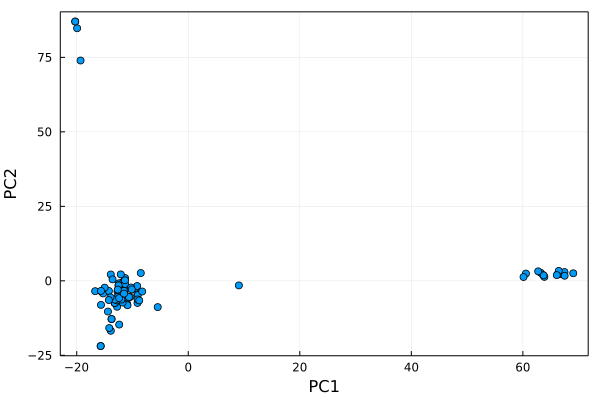

In [10]:
# flip the embeddings for PCA
rbp_embeddings_flipped = zeros(Int64, 10000, length(RBPbase.ProteinSeq))
for i in range(1, length=length(RBPbase.ProteinSeq))
    rbp_embeddings_flipped[:,i] = rbp_embeddings[i]
end

# compute the PCA
pca = fit(PCA, rbp_embeddings_flipped, pratio=1, maxoutdim=4)
proj = projection(pca) # each column is a principal component
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
rbp_transformed = MultivariateStats.transform(pca, rbp_embeddings_flipped)
h = plot(rbp_transformed[1,:], rbp_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

#### PCA of loci embeddings

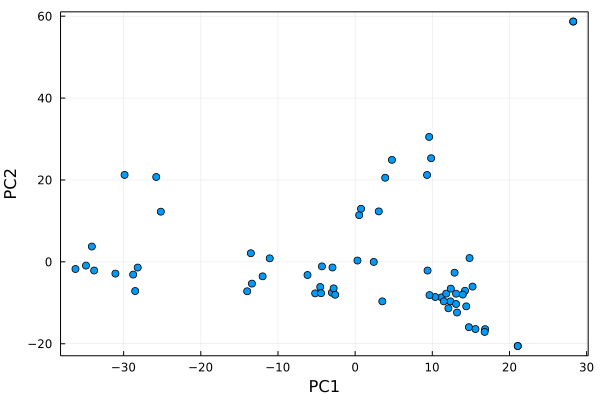

In [13]:
# flip the embeddings for PCA
loci_embeddings_flipped = zeros(Int64, 10000, length(LociBase))
for i in range(1, length=length(LociBase))
    loci_embeddings_flipped[:,i] = loci_embeddings[i]
end

# compute the PCA
pca = fit(PCA, loci_embeddings_flipped, pratio=1, maxoutdim=4)
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
loci_transformed = MultivariateStats.transform(pca, loci_embeddings_flipped)
h = plot(loci_transformed[1,:], loci_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

We could color these by serotype but as seen above almost all of the serotypes are unique so the colors would al be unique colors as well. What's important here is to see some variation across the serotypes in two dimensions. We also have indications that some serotypes are more alike than others and cluster together a little. What is the reason for this? Do these possess similar genes?

#### PCA of the signatures colored by RBP

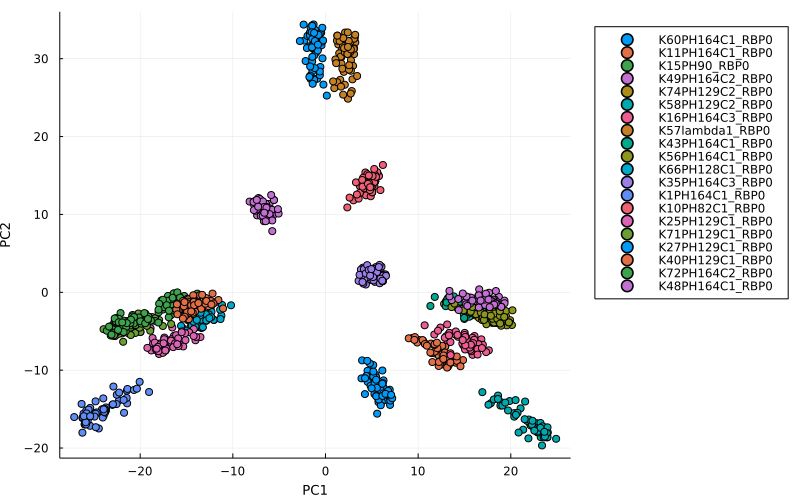

In [15]:
# flip the signatures for PCA
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = []
i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    push!(labels, rbp_names[key[2]])
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    push!(labels, rbp_names[key[2]])
    i = i+1
end

# compute the PCA
pca = fit(PCA, signatures_flipped, pratio=1, maxoutdim=4);

# visualize
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter, legend = :outertopright)
for label in unique(labels)
    idx = [i for (i, lab) in enumerate(labels) if lab == label]
    plot!([signatures_transformed[1, idx]], [signatures_transformed[2, idx]], seriestype=:scatter, label=label)  
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

Here, we see the lower dimensional projection of the RBP-loci signatures, colored by unique RBP in the dataset (there are 19 unique RBPs that are validated by structure and pass the mono filter, leading to 29 positive interactions; 28/05/22). Interestingly, we do see that the unique RBP-loci interactions cluster by RBP, and thus by serotype, quite well. Which indicates that we would be able to learn to discriminate between serotypes pretty well. However, we want to discriminate between pos and negative interactions (too).

In [16]:
savefig(h, results_dir*"/HDC_PCA_signatures_RBPcolor.png")

#### Exploring similarities between the embeddings

Idea: compute the cosine similarities between all HDC embeddings and compare that with alignment similarity scores.

##### a) RBP similarities

In [15]:
# read RBP alignment matrix
rbp_sim = readdlm(general_dir*"/RBPbaseValencia.fasta_score_matrix.txt", '\t');

# compute cosine similarities for RBP embeddings
rbp_embeddings_sim = zeros(Float64, length(rbp_embeddings), length(rbp_embeddings))
for i in range(1, length=length(rbp_embeddings))
    for j in range(1, length=length(rbp_embeddings))
        rbp_embeddings_sim[i,j] = cos_sim(rbp_embeddings[i], rbp_embeddings[j])
    end
end

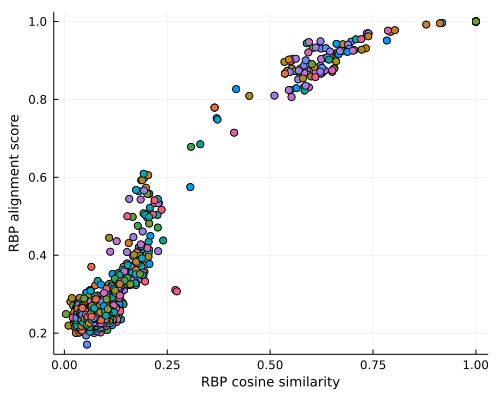

In [16]:
# Make RBP scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(rbp_embeddings))
    for j in range(1, length=length(rbp_embeddings))
        plot!([rbp_embeddings_sim[i, j]], [rbp_sim[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="RBP cosine similarity", xguidefontsize=9, ylabel="RBP alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [17]:
savefig(h, results_dir*"/HDC_scatter_RBPs_cosine_alignment.png")

In [18]:
# compute RBP correlation
flat_rbp_sim = vcat(rbp_sim...)
flat_rbp_embeddings_sim = vcat(rbp_embeddings_sim...)
cor(flat_rbp_sim, flat_rbp_embeddings_sim)

0.9585111302181624

##### b) Loci similarities

In [17]:
# compute loci embeddings w/ proteins (multi-instance)
basis = Dict(c=>BipolarHDV() for c in alphabet);
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 3) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.bind(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [18]:
# read loci alignment matrix
loci_sim = readdlm(general_dir*"/kaptive_results_all_loci.fasta_score_matrix.txt", '\t');

# compute cosine similarities for loci embeddings
loci_embeddings_sim = zeros(Float64, length(loci_embeddings), length(loci_embeddings))
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        loci_embeddings_sim[i,j] = cos_sim(loci_embeddings[i], loci_embeddings[j])
    end
end

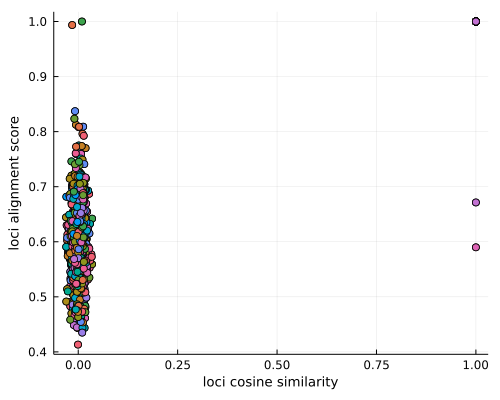

In [19]:
# Make loci scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        plot!([loci_embeddings_sim[i, j]], [loci_sim[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="loci cosine similarity", xguidefontsize=9, ylabel="loci alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [21]:
savefig(h, results_dir*"/HDC_scatter_locibind_cosine_alignment.png")

In [20]:
# compute loci correlation
flat_loci_sim = vcat(loci_sim...)
flat_loci_embeddings_sim = vcat(loci_embeddings_sim...)
cor(flat_loci_sim, flat_loci_embeddings_sim)

0.6404398308352918

We see that the correlation between the RBP embeddings scores and alignment scores is very good, which indicates that the (evolutionary) information of the RBPs is well captured in the embeddings (for as far as we can see alignment as a proxy for this information). However, for the loci embeddings, we don't see quite a high correlation between the alignment scores and embedding similarities. This could be due to several reasons:

- there is a disconnection between the similarity score of alignments at the DNA level and the embeddings in a multi-instance setting at the protein level.
- alignment itself is a bad measure for similarity for these long stretches of DNA (or the particular type of alignment).
- the computed embeddings don't contain the information we want and/or multi-instance setting is not well defined/computed.

Sometimes we get a slightly better result, a correlation of around 57% with a BipolarHDV. Depends on the random nature of the vectors too I suppose. But still not amazingly good.

##### c) Further analysis of loci similarities

We will try a second approach: compute the similarities between all loci proteins separately, both with alignment and embeddings, and then compare both. If they turn out appropriately, then the problem is either the loci alignment itself or the multi-instance combo.

In [24]:
# get all proteins in a list
all_loci_proteins = []
for (key, value) in LociBase
    for protein in value
        push!(all_loci_proteins, protein)
    end
end

In [29]:
# do pairwise alignments
score_matrix = zeros(length(all_loci_proteins), length(all_loci_proteins))
score_model = AffineGapScoreModel(BLOSUM62, gap_open=-5, gap_extend=-1)
p = Progress(Int64(round((length(all_loci_proteins)^2/2), digits=0)))
for i in 1:length(all_loci_proteins)
    for j in i:length(all_loci_proteins)
        res = pairalign(LocalAlignment(), all_loci_proteins[i], all_loci_proteins[j], score_model);
        aln = alignment(res)
        score_matrix[i,j] = count_matches(aln) / count_aligned(aln)
        next!(p)
    end
end

# complete the matrix and adjust the diagonal for double score
score_matrix = (score_matrix + score_matrix')
score_matrix = score_matrix - Diagonal(score_matrix)/2

Progress: 100%|█████████████████████████████████████████| Time: 0:20:31


1204×1204 Matrix{Float64}:
 1.0       0.211538  0.252475  0.245353  …  0.258786  0.244373  0.232
 0.211538  1.0       0.246809  0.226415     0.266949  0.237569  0.273973
 0.252475  0.246809  1.0       0.211401     0.229755  0.236538  0.254737
 0.245353  0.226415  0.211401  1.0          0.2277    0.262582  0.221461
 0.25      0.25974   0.309859  0.253623     0.294118  0.236364  0.22561
 0.247748  0.261468  0.208     0.236786  …  0.245487  0.208729  0.238197
 0.237342  0.208661  0.188406  0.231343     0.211679  0.204461  0.242105
 0.211429  0.232704  0.237192  0.216518     0.238956  0.228797  0.215054
 0.241497  0.243902  0.231061  0.223844     0.22069   0.217054  0.220657
 0.225225  0.27193   0.223565  0.237143     0.225118  0.197143  0.232416
 0.228758  0.237288  0.207877  0.232687  …  0.242925  0.21663   0.223476
 0.219828  0.205224  0.213235  0.2457       0.233151  0.188596  0.255319
 0.237143  0.238095  0.262443  0.221014     0.215054  0.233766  0.231608
 ⋮                          

In [40]:
# compute loci embeddings for all proteins 
basis = Dict(c=>BipolarHDV() for c in alphabet);
loci_embeddings = Array{BipolarHDV}(undef, length(all_loci_proteins))
for (i, protein) in enumerate(all_loci_proteins)
    protein_hdv = sequence_embedding(string(protein), basis, 3)
    loci_embeddings[i] = protein_hdv
end

In [41]:
# compute cosine similarities for all loci proteins
loci_embeddings_sim = zeros(Float64, length(loci_embeddings), length(loci_embeddings))
for i in 1:length(loci_embeddings)
    for j in 1:length(loci_embeddings)
        loci_embeddings_sim[i,j] = cos_sim(loci_embeddings[i], loci_embeddings[j])
    end
end

In [43]:
# Make loci scatter plot
flat_loci_sim = vcat(score_matrix...)
flat_loci_embeddings_sim = vcat(loci_embeddings_sim...)
h = plot(seriestype=:scatter)
for i in range(1, length=20000)
    plot!([flat_loci_embeddings_sim[i]], [flat_loci_sim[i]], seriestype=:scatter, label="")
end
plot!(xlabel="loci proteins cosine similarity", xguidefontsize=9, ylabel="loci alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [45]:
savefig(h, results_dir*"/HDC_scatter_individuallociproteins_cosine_alignment.png")

In [44]:
cor(flat_loci_sim, flat_loci_embeddings_sim)

0.9401870360921616

## 4 - Simple evaluation

In [23]:
# covert dictionaries to arrays for training
sign_pos_list = [value for (key, value) in signatures_pos]
sign_neg_list = [value for (key, value) in signatures_neg]
signatures_pos_array = convert(Array{BipolarHDV}, sign_pos_list)
signatures_neg_array = convert(Array{BipolarHDV}, sign_neg_list)

1211-element Vector{BipolarHDV}:
 [-1, 1, -1, -1, 1, 1, -1, 1, -1, 1  …  0, 1, -1, -1, 1, -1, 1, 1, 1, 1]
 [1, 1, 1, -1, 0, 0, -1, 1, -1, 1  …  1, -1, -1, -1, 1, 1, 0, 1, 1, -1]
 [1, 1, 0, 1, 0, 1, -1, 0, 1, 1  …  0, -1, 1, 1, 1, 1, 1, 1, 0, 1]
 [1, 1, 1, 1, 1, 1, -1, -1, -1, 0  …  1, 1, -1, -1, 1, 1, 1, 1, -1, 1]
 [-1, 0, 1, -1, 1, -1, -1, -1, 1, 1  …  1, -1, 1, -1, 1, 1, -1, 1, -1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, -1, 1  …  1, -1, 1, 1, 1, -1, 1, 0, 1, 1]
 [-1, -1, -1, 1, -1, 1, 1, -1, 1, -1  …  1, 1, 1, 1, -1, -1, 1, 1, -1, 0]
 [-1, 1, 1, 1, 1, 1, -1, 1, -1, 1  …  0, 0, 0, -1, 1, -1, 1, 1, -1, 1]
 [1, 1, 0, 1, -1, 1, -1, -1, 1, 1  …  -1, 1, 1, 0, 1, -1, 1, 1, 1, -1]
 [-1, -1, -1, 1, 1, 1, 1, -1, 1, -1  …  1, 1, 1, -1, -1, 1, 1, -1, 1, -1]
 [1, -1, 1, 1, 1, 1, -1, -1, -1, -1  …  1, -1, -1, -1, 1, 1, -1, 1, 1, -1]
 [-1, -1, -1, 1, 0, 1, -1, 1, 1, -1  …  1, 0, 1, 0, 1, -1, 1, -1, -1, 0]
 [0, 1, 0, 1, -1, 1, 1, 1, -1, 0  …  0, -1, -1, 0, 0, 1, 1, 1, -1, 1]
 ⋮
 [-1, 1, 1, -1, 1, 1, -1, -1, -

In [35]:
# shuffle and split in train-test
sign_pos = shuffle(signatures_pos_array)
sign_neg = shuffle(signatures_neg_array)
cutoff_pos = Int(round(length(signatures_pos_array)*0.75))
cutoff_neg = Int(round(length(signatures_neg_array)*0.75))
training_pos = sign_pos[1:cutoff_pos]
training_neg = sign_neg[1:cutoff_neg]
testing_pos = sign_pos[cutoff_pos+1:end]
testing_neg = sign_neg[cutoff_neg+1:end]

# train classes (aggregate)
training_pos_agg = HyperdimensionalComputing.aggregate(training_pos)
training_neg_agg = HyperdimensionalComputing.aggregate(training_neg);

In [34]:
# compute distances (Cosine sim for RealHDVs)
preds_pos = [cos_sim(training_pos_agg, x) > cos_sim(training_neg_agg, x) ? 1 : 0 for x in testing_pos]
preds_neg = [cos_sim(training_pos_agg, x) > cos_sim(training_neg_agg, x) ? 1 : 0 for x in testing_neg];

In [36]:
accuracy = (sum(preds_pos .== 1) + sum(preds_neg .== 0)) / (length(testing_pos)+length(testing_neg))

0.02258064516129032

In [37]:
dist_pos_test = [cos_sim(training_pos_agg, x) for x in testing_pos]
dist_neg_test = [cos_sim(training_pos_agg, x) for x in testing_neg]

# make plots
hist = histogram(dist_pos_test, label="positive test", alpha=0.7, legend=:topleft, nbins=40)
histogram!(dist_neg_test, label="negative test", alpha=0.7, nbins=30)
savefig(hist, results_dir*"/HDC_histogram.png")

rank_plot = plot(sort!(dist_pos_test), label="positive test", alpha=0.7, legend=:bottomright, xlabel="rank", ylabel="Cosine sim")
plot!(sort!(dist_neg_test), label="negative test", alpha=0.7)
savefig(rank_plot, results_dir*"/HDC_rank_plot.png")

If we compute the accuracy very naively, we get a very bad result. In essence, the similarity to the positive aggregated vector will always be greater than the similarity to the negative aggregate, and thus all predictions are positive...

We also see this difficulty on a histogram, the positive scores overlap completely with the negative scores. However, a rank plot does seem to indicate that overall, separation between pos+ and negatives can be posible. This is what we should check out: if we predict for all of the bacterial strains, how do these scores compare: do the positive interactions have greater scores than the negative interactions, given a particular bacterial strain?!

## 5 - Cross-validation

In this section, we will try to answer the question above by implementing a Stratified KFold approach that loops over all of the data points and makes predictions. These predictions are then collected in a matrix with the same shape as our interaction matrix. Finally, the matrix is looked at strain by strain and ranked to get a sense of where the positive interactions occur for each bacterium. These ranks are then used to compute the mean reciprocal rank.

In [44]:
# covert dictionaries to arrays for training
positions = vcat([key for (key, value) in signatures_pos], [key for (key, value) in signatures_neg])
sign_pos_list = [value for (key, value) in signatures_pos]
sign_neg_list = [value for (key, value) in signatures_neg]
signatures_pos_array = convert(Array{BipolarHDV}, sign_pos_list)
signatures_neg_array = convert(Array{BipolarHDV}, sign_neg_list);

In [40]:
# aggregate the signatures and labels for cross-validation
signatures = vcat(signatures_pos_array, signatures_neg_array)
labels = vcat([1 for x in signatures_pos], [0 for x in signatures_neg]);

In [53]:
# perform the cross-validation and keep the scores
similarities = Dict()
for (train_indices, test_indices) in CrossValidation.StratifiedKFold(labels, n_folds=5, 
        shuffle=true, random_state=42)
    # define training and test data
    x_train = signatures[train_indices]
    y_train = labels[train_indices]
    x_test = signatures[test_indices]
    y_test = labels[test_indices]
    
    # train the positive aggregate
    pos_aggregate = HyperdimensionalComputing.aggregate(x_train[y_train .== 1])
    
    # compute similarities to the pos aggregate and keep the index
    similarities_k = [cos_sim(pos_aggregate, x) for x in x_test]
    for (i, test_i) in enumerate(test_indices)
        similarities[test_i] = similarities_k[i]
    end
end

In [12]:
# fill in a prediction matrix

# sort the matrix per row and compute

No documentation found.

`ScikitLearn.Skcore.StratifiedKFold` is a `Function`.

```
# 1 method for generic function "StratifiedKFold":
[1] StratifiedKFold(y::AbstractArray; n_folds, shuffle, random_state) in ScikitLearn.Skcore at /Users/dimi/.julia/packages/ScikitLearn/ssekP/src/cross_validation.jl:136
```


In [ ]:
"""
Here, we perform a 10-fold CV over the loci, just like we do to evaluate the
binary classifiers in Python.
"""
loci_known = [x for x in range(1, length=length(LociBase)) 
                if (any(isequal.(interaction_matrix[x,:], 0))) 
                    || (any(isequal.(interaction_matrix[x,:], 1)))]

# shuffle loci
loci_shuffle = shuffle(loci_known)

# divide into 10 groups
group_size = div(length(loci_shuffle), 10) + 1
get_groups(x, n) = [x[i:min(i+n-1,length(x))] for i in 1:n:length(x)]
loci_groups = get_groups(loci_shuffle, group_size)

# loop over groups
loci_nr = []; rbp_nr = []; scores = []; scores_pos = []; labels = []
for group in loci_groups
    # compute signatures for training and testing parts (group = test)
    signatures_train_pos = []
    signatures_train_neg = []
    signatures_test = []
    for (i, loci_embedding) in enumerate(loci_embeddings)
        for (j, rbp_embedding) in enumerate(rbp_embeddings)
            # training pos interaction
            if isequal(interaction_matrix[i,j], 1) && i ∉ group
                push!(signatures_train_pos, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
            # training neg interaction
            elseif isequal(interaction_matrix[i,j], 0) && i ∉ group
                push!(signatures_train_neg, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
            # test interaction
            elseif isequal(interaction_matrix[i,j], 1) && i in group
                push!(signatures_test, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
                push!(loci_nr, i-1) # -1 to cope with indexing python
                push!(rbp_nr, j-1)
                push!(labels, interaction_matrix[i,j])
            elseif isequal(interaction_matrix[i,j], 0) && i in group
                push!(signatures_test, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
                push!(loci_nr, i-1)
                push!(rbp_nr, j-1)
                push!(labels, interaction_matrix[i,j])
            end
        end
    end

    # convert signatures
    signatures_train_pos = convert(Array{BipolarHDV}, signatures_train_pos)
    signatures_train_neg = convert(Array{BipolarHDV}, signatures_train_neg)
    signatures_test = convert(Array{BipolarHDV}, signatures_test)
    println("train size:", length(signatures_train_pos)+length(signatures_train_neg))
    println("test size:", length(signatures_test))
    
    # aggregate training signatures
    signatures_pos_agg = HyperdimensionalComputing.aggregate(signatures_train_pos)
    signatures_neg_agg = HyperdimensionalComputing.aggregate(signatures_train_neg)

    # compute distance/similarity to test signatures
    for test in signatures_test
        score_pos_agg = cos_sim(signatures_pos_agg, test)
        score_neg_agg = cos_sim(signatures_neg_agg, test)
        push!(scores, score_pos_agg/score_neg_agg) # > 1 then pos, < 1 then neg
        push!(scores_pos, score_pos_agg)
    end
end

# results pos vs. neg
results = DataFrame(locus=loci_nr, rbps=rbp_nr, scores=scores, label=labels)
CSV.write(results_dir*"/results_HDC_grouped10CV_"*data_suffix*".csv", results)

# results pos only
results = DataFrame(locus=loci_nr, rbps=rbp_nr, scores=scores_pos, label=labels)
CSV.write(results_dir*"/results_HDCpos_grouped10CV_"*data_suffix*".csv", results)

# examine scores
histogram(scores, xlabel="score", ylabel="count")
sum(scores .< 1)/length(scores)

## 6 - Legacy code

In [2]:
###
# Pairwise alignments for RBP detection
using FASTX
#using BioSequences
using BioAlignments
using DelimitedFiles
using LinearAlgebra
using ProgressMeter
sequences = []
reader = FASTA.Reader(open("/Users/Dimi/Desktop/rbps_fasta.fasta", "r"))
for record in reader
    seq = FASTA.sequence(record)
    push!(sequences, seq)
end
println(length(sequences))

# do pairwise alignments
score_matrix = zeros(length(sequences), length(sequences))
score_model = AffineGapScoreModel(BLOSUM62, gap_open=-5, gap_extend=-1)
p = Progress(Int64(round((length(sequences)^2/2), digits=0)))
for i in 1:length(sequences)
    for j in i:length(sequences)
        res = pairalign(LocalAlignment(), sequences[i], sequences[j], score_model);
        aln = alignment(res)
        score_matrix[i,j] = count_matches(aln) / count_aligned(aln)
        next!(p)
    end
end

# complete the matrix and adjust the diagonal for double score
score_matrix = (score_matrix + score_matrix')
score_matrix = score_matrix - Diagonal(score_matrix)/2
###

4189


Progress: 100%|█████████████████████████████████████████| Time: 5:38:5539m


4189×4189 Matrix{Float64}:
 1.0       0.236364  0.227437  0.241071  …  0.236434  0.215385  0.247232
 0.236364  1.0       0.266497  0.267148     0.24197   0.262774  0.248193
 0.227437  0.266497  1.0       0.262097     0.243902  0.242857  0.238411
 0.241071  0.267148  0.262097  1.0          0.253571  0.268482  0.25
 0.244845  0.265714  0.246951  0.255814     0.234756  0.251515  0.233161
 0.233083  0.234146  0.24697   0.22807   …  0.228826  0.237885  0.243631
 0.239175  0.256345  0.231579  0.232068     0.235756  0.253444  0.226212
 0.238589  0.230563  0.238832  0.224576     0.23092   0.237852  0.223986
 0.256757  0.25656   0.248996  0.244344     0.245399  0.248157  0.237094
 0.217842  0.230583  0.24374   0.237903     0.218415  0.241096  0.253304
 0.210425  0.252358  0.236842  0.246154  …  0.235808  0.254642  0.241627
 0.21499   0.234483  0.238866  0.241935     0.250531  0.257979  0.2537
 0.215569  0.25537   0.24187   0.239496     0.245077  0.257979  0.260128
 ⋮                            

In [3]:
writedlm("/Users/Dimi/Desktop/rbps_training_score_matrix.txt", score_matrix)

In [5]:
###
sequences_2021 = []
reader = FASTA.Reader(open("/Users/Dimi/Desktop/rbps2021_fasta.fasta", "r"))
for record in reader
    seq = FASTA.sequence(record)
    push!(sequences_2021, seq)
end
println(length(sequences_2021))

score_matrix = zeros(length(sequences), length(sequences_2021))
score_model = AffineGapScoreModel(BLOSUM62, gap_open=-5, gap_extend=-1)
p = Progress(Int64(round((length(sequences)*length(sequences_2021)), digits=0)))
for i in 1:length(sequences)
    for j in 1:length(sequences_2021)
        res = pairalign(LocalAlignment(), sequences[i], sequences_2021[j], score_model);
        aln = alignment(res)
        score_matrix[i,j] = count_matches(aln) / count_aligned(aln)
        next!(p)
    end
end

writedlm("/Users/Dimi/Desktop/rbps_traintest_score_matrix.txt", score_matrix)
###

1987


Progress: 100%|█████████████████████████████████████████| Time: 5:09:04
